<a href="https://www.kaggle.com/code/shreyasdomde/weather-detection?scriptVersionId=165412646" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install tensorflow[and-cuda]

  Preparing metadata (setup.py) ... - \ done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 MB 8.0 MB/s eta 0:00:

In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, callbacks

import warnings
warnings.filterwarnings("ignore")

2024-03-04 14:33:32.003528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 14:33:32.003596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 14:33:32.005135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
datadir = '/kaggle/input/weather-dataset/dataset'

# 😶‍🌫️ Exploring the dataset

In [4]:
climates = {cl: len(os.listdir(os.path.join(datadir, cl))) for cl in os.listdir(datadir)}

<Axes: >

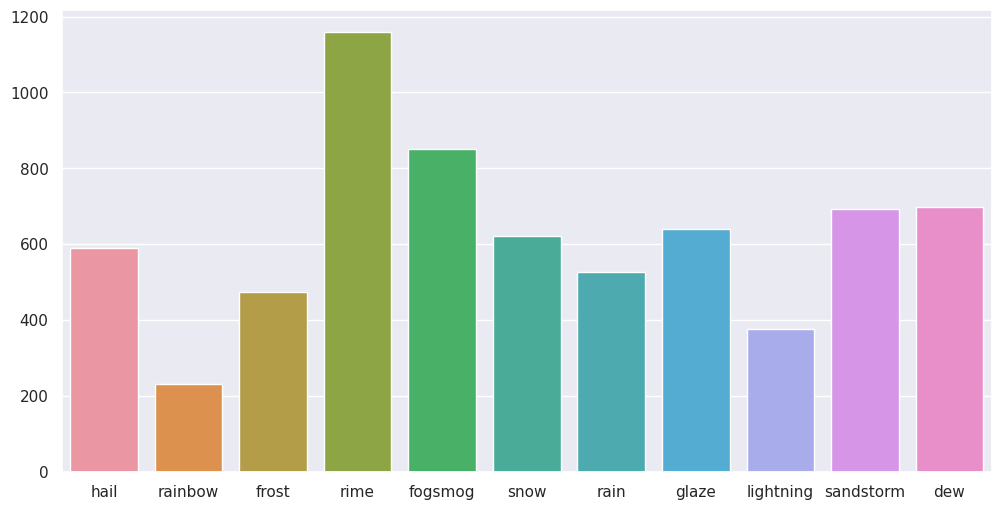

In [5]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.barplot(x=list(climates.keys()), y=list(climates.values()))

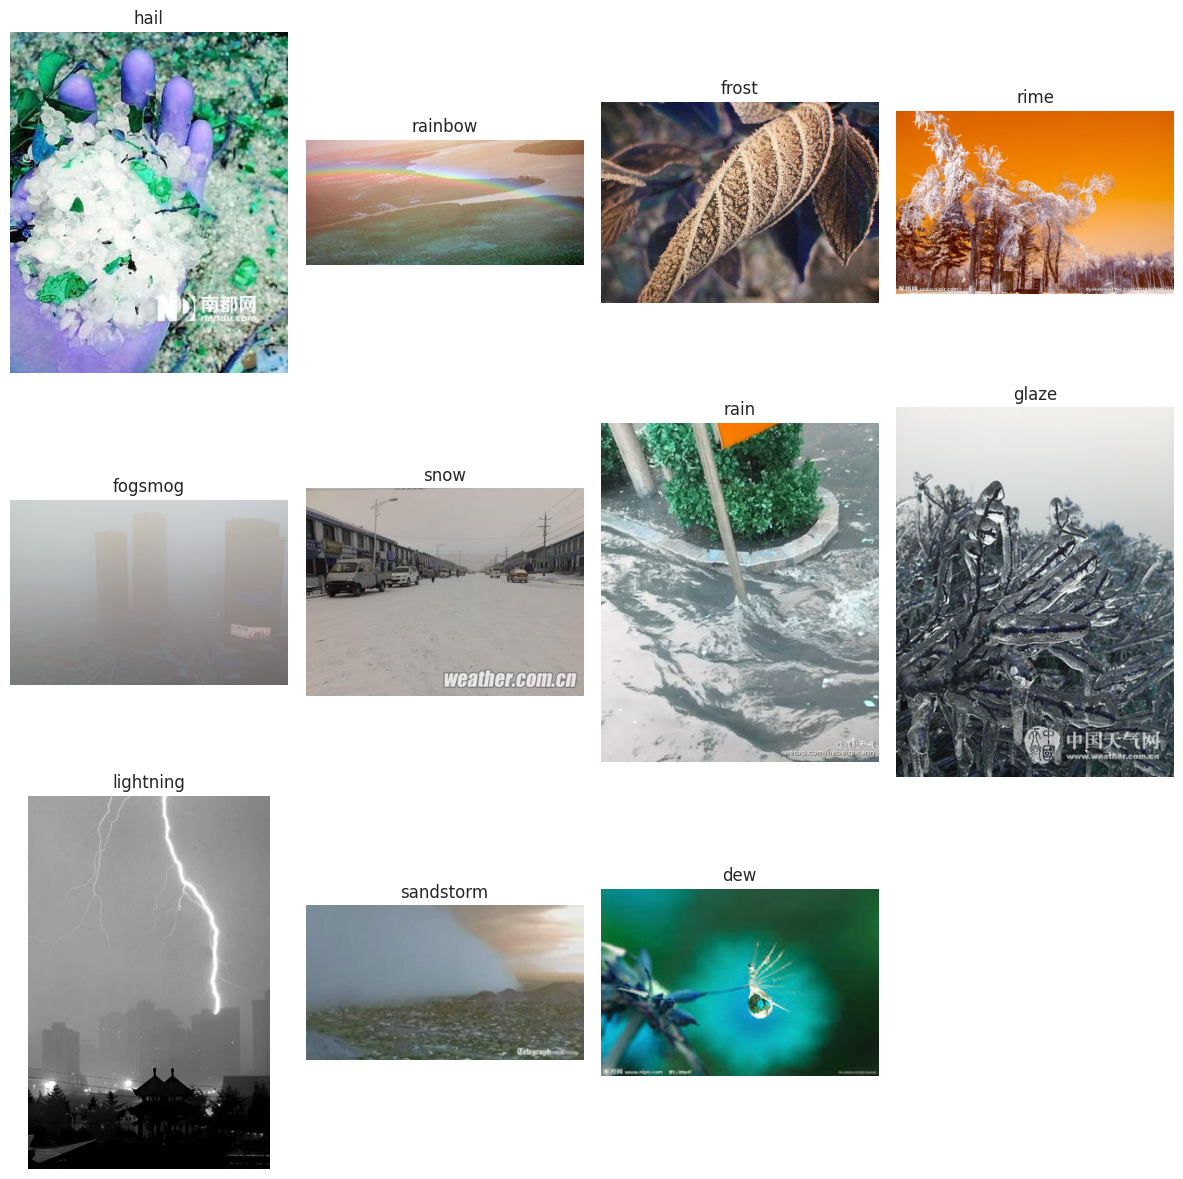

In [6]:
fig = plt.figure(figsize=(12, 12)) 
rows = 3
columns = 4

for i, cl in enumerate(climates.keys()):
    img_name = os.listdir(os.path.join(datadir, cl))[random.randrange(0, 100)]
    img_path = os.path.join(datadir, cl, img_name)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(img)
    plt.title(cl)
    
plt.tight_layout()
plt.show()

# ✂️ Splittinng dataset

In [7]:
filepaths = []
labels = []
for i in climates.keys():
    img_path = datadir+'/'+i
    for imgs in os.listdir(img_path):
        filepaths.append(os.path.join(img_path, imgs))
        labels.append(i)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [8]:
df.head()

,filepaths,labels
0,/kaggle/input/weather-dataset/dataset/hail/010...,hail
1,/kaggle/input/weather-dataset/dataset/hail/037...,hail
2,/kaggle/input/weather-dataset/dataset/hail/028...,hail
3,/kaggle/input/weather-dataset/dataset/hail/007...,hail
4,/kaggle/input/weather-dataset/dataset/hail/007...,hail


# 🎋 Preprocessing Images

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=44) 

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.2
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [11]:
train_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training'
)

val_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset='validation'
)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.


In [12]:
test_data = train_datagen.flow_from_dataframe(
    df_test, 
    x_col = 'filepaths',
    y_col = 'labels',
    color_mode = 'rgb',
    batch_size = 64
)

Found 1373 validated image filenames belonging to 11 classes.


# 🪸 Training models

In [13]:
model = tf.keras.Sequential([
    
    layers.Resizing(100, 100),
    layers.Rescaling(1./255),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=11, activation='softmax'),
])

In [14]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [15]:
model.build((None, 200, 200, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        1

In [16]:
EPOCHS = 100
early_stop = callbacks.EarlyStopping(
    patience=10,
    monitor='val_loss'
)

In [17]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = EPOCHS,
    batch_size = 64,
    callbacks = [early_stop]
)

Epoch 1/100


I0000 00:00:1709562840.495788     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 [==============================] - 130s 885ms/step - loss: 1.5036 - accuracy: 0.5264 - val_loss: 4.9420 - val_accuracy: 0.1459
Epoch 2/100
138/138 [==============================] - 84s 610ms/step - loss: 1.1711 - accuracy: 0.6022 - val_loss: 3.3643 - val_accuracy: 0.1942
Epoch 3/100
138/138 [==============================] - 84s 607ms/step - loss: 1.1162 - accuracy: 0.6318 - val_loss: 1.7131 - val_accuracy: 0.4950
Epoch 4/100
138/138 [==============================] - 84s 606ms/step - loss: 1.0449 - accuracy: 0.6557 - val_loss: 1.2713 - val_accuracy: 0.5962
Epoch 5/100
138/138 [==============================] - 84s 610ms/step - loss: 0.9833 - accuracy: 0.6607 - val_loss: 1.7741 - val_accuracy: 0.5141
Epoch 6/100
138/138 [==============================] - 85s 614ms/step - loss: 0.9675 - accuracy: 0.6801 - val_loss: 1.0004 - val_accuracy: 0.6673
Epoch 7/100
138/138 [==============================] - 85s 613ms/step - loss: 0.9037 - accuracy: 0.6906 - val_loss: 1.2006 - val_accura

# Evaluating model

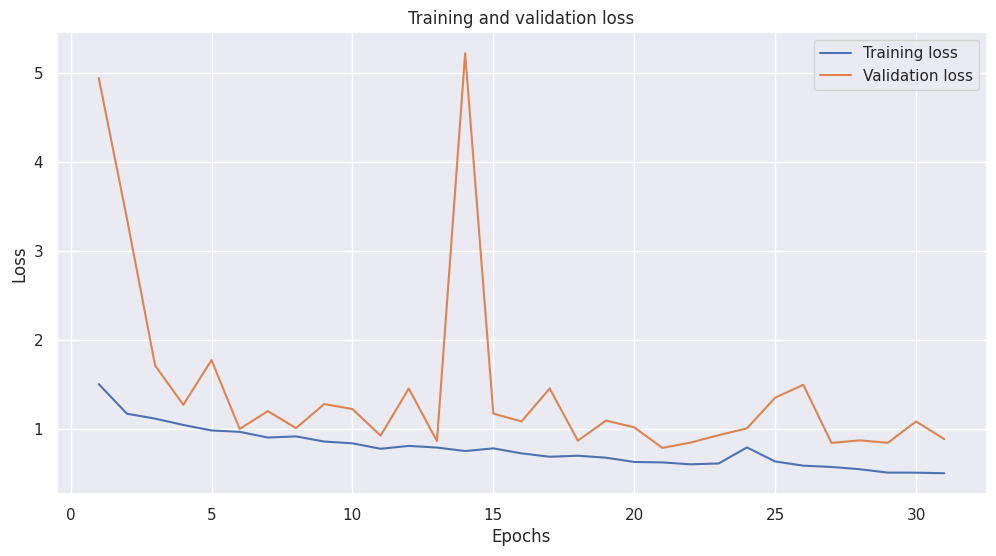

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

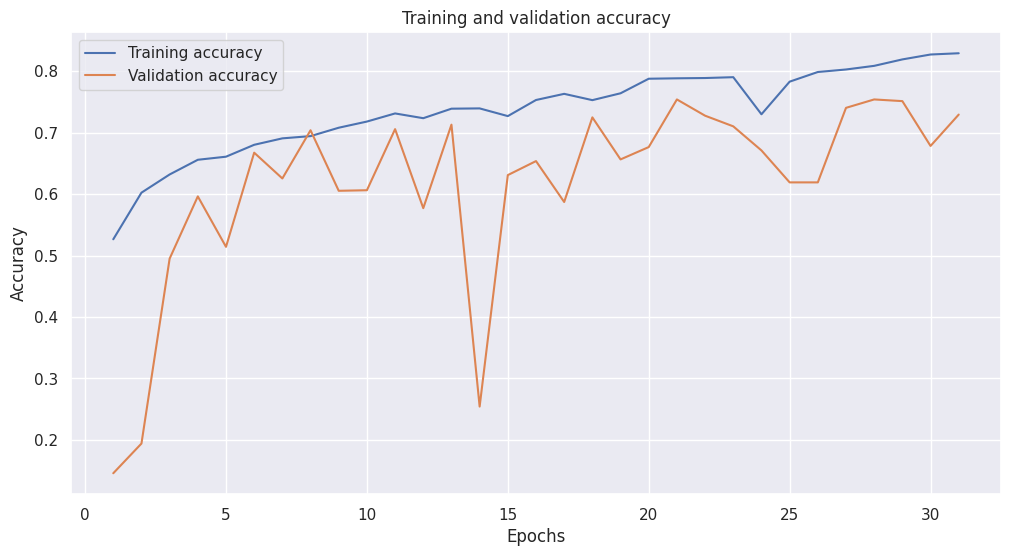

In [19]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
y_pred = model.predict(test_data)
model.evaluate(test_data)

22/22 [==============================] - 22s 1s/step - loss: 0.9732 - accuracy: 0.7036


[0.9732114672660828, 0.7035688161849976]

In [21]:
classes = {val:key for key, val in test_data.class_indices.items()}
def vis_pred(ind):
    rows, columns = 3, 4
    x, y = next(iter(train_data))
    fig = plt.figure(figsize=(10, 10))
    for i in range(rows * columns):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(x[ind+i] / 255)
        plt.title(f'Original: {classes[np.argmax(y[ind + i])]} \nPredicted: {classes[np.argmax(y_pred[ind + i])]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

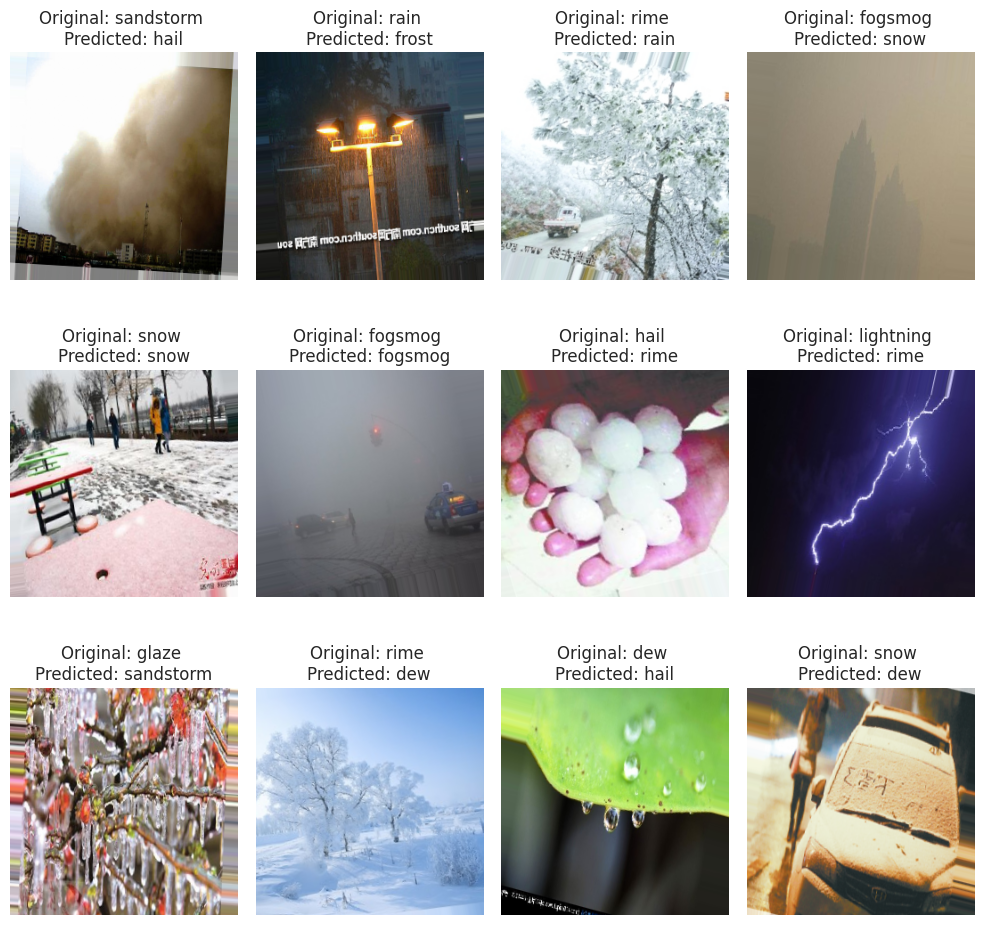

In [22]:
vis_pred(10)